In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import cdist

In [6]:
def plot_img(img, fig_size = (10, 10), colorness='gray'):
    plt.figure(figsize = fig_size)
    plt.imshow(img, colorness)
    plt.xticks([]), plt.yticks([])
    plt.show()
def reject_outliers(data, m = 2.):
    d = np.abs(data[:, 1] - np.median(data[:, 1]))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

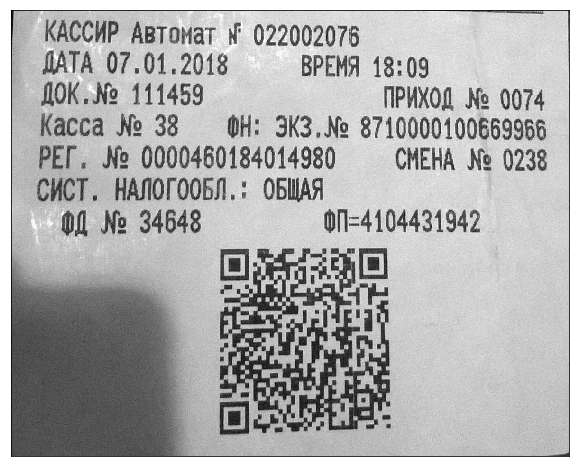

In [7]:
CURRENT_PIC = 'TestPhotos/qr_cop.jpg'
img = cv2.imread(CURRENT_PIC, 0) # Загрузка изображения в grayscale
plot_img(img)

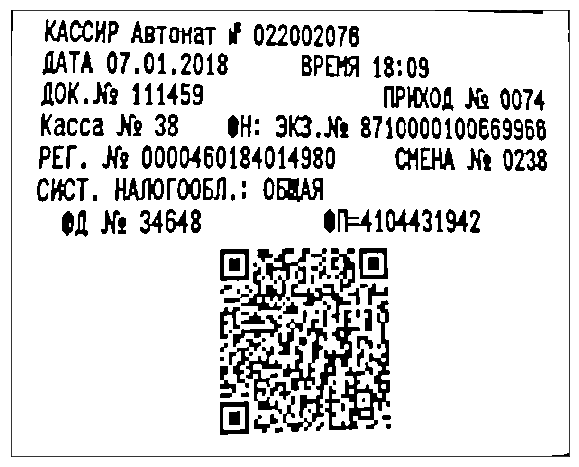

In [11]:
# QR-коды в датасете сняты на телефон и сильно зашумлены, поэтому требуется некоторая предобработка
# Размытие -> бинаризация -> opening morphology(для очистки шумов)
blured = cv2.GaussianBlur(img,(7,7),0)
bin_img = cv2.adaptiveThreshold(blured,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,89,20)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, np.ones((5, 5)))
plot_img(bin_img)

## Алгоритм поиска finder pattern'ов
1. Поиск границ алгоритмом Кэнни
2. Поиск контуров
3. Поиск трех наиболее подходящих прямоугольников

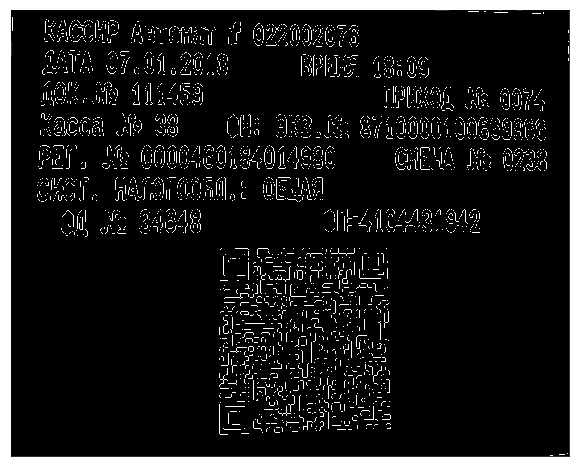

In [12]:
edges = cv2.Canny(bin_img,100,100*2)
plot_img(edges)
im2,contours,hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

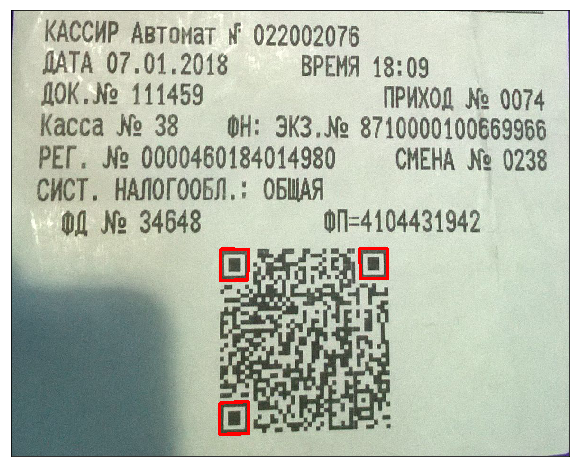

In [18]:
contours_areas = sorted(contours, key=cv2.contourArea, reverse = True)[:70]
orig_img = cv2.imread(CURRENT_PIC)
qr_moments = [] 
approxes = []
approx_lines = []
for i, countour in enumerate(contours_areas):
    perimeter = cv2.arcLength(countour, True)
    approx = cv2.approxPolyDP(countour, 0.02*perimeter, True)
    approxes.append(approx)
    if len(approx_lines) != 4 and len(approx) == 4:
        M = cv2.moments(countour)
        if M['m00'] == 0:
            cx, cy = 0, 0
        else:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        if qr_moments and np.any(cdist(np.array([[cx, cy]]), np.array(qr_moments)) < 10):
            continue
        qr_moments.append([cx, cy])
        approx_lines.append([i, perimeter])
approx_lines = reject_outliers(np.array(approx_lines))
for indx, _ in approx_lines:
    cv2.drawContours(orig_img, [approxes[int(indx)]], -1, (255,0,0), 5)
plot_img(orig_img)

## TODO
* Гарантировано находить все FIB'ы, которых может быть больше 1. 
* Валидировать найденные контуры.
* Правильная ориентация QR кода по finder pattern'ам. По центройдам построить треугольник!
* Попробовать другой алгоритм поиска. Возможно, идти по изображению прямой и находить соотношения в FIB 1:1:3:1:1.